In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import yaml

from src.models.ts2vec_src.ts2vec import TS2Vec
from src.data.preprocessing import read_data, preprocessing, data_to_np_tensor

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_28824/2067375741.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data loading

In [3]:
data = read_data('data/all_tickers.csv')

data['Date'] = data['Datetime'].dt.date
data['Day_week'] = data['Datetime'].dt.day_name()
data['Time'] = data['Datetime'].dt.time

data = data[data['Day_week'] != 'Saturday']
data = data[
    (data['Time'] >= pd.to_datetime('17:30:00').time()) & \
    (data['Time'] < pd.to_datetime('22:59:00').time())
]

print(data.shape)
data.head()

(16411517, 10)


,Date,Time,Open,High,Low,Close,Volume,Datetime,Stock,Day_week
31,2024-01-30,22:55:00,134.38,134.38,134.38,134.38,100,2024-01-30 22:55:00,A,Tuesday
32,2024-01-30,22:54:00,134.41,134.42,134.41,134.42,300,2024-01-30 22:54:00,A,Tuesday
33,2024-01-30,22:51:00,134.36,134.37,134.36,134.37,300,2024-01-30 22:51:00,A,Tuesday
34,2024-01-30,22:40:00,134.03,134.03,134.03,134.03,100,2024-01-30 22:40:00,A,Tuesday
35,2024-01-30,22:39:00,134.00,134.00,134.00,134.00,100,2024-01-30 22:39:00,A,Tuesday


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16411517 entries, 31 to 35605
Data columns (total 10 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Date      object        
 1   Time      object        
 2   Open      float64       
 3   High      float64       
 4   Low       float64       
 5   Close     float64       
 6   Volume    int64         
 7   Datetime  datetime64[ns]
 8   Stock     object        
 9   Day_week  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 1.3+ GB


# Dates exploration

In [5]:
print('N unique dates: ', data['Date'].nunique())

N unique dates:  252


In [6]:
days_distributions = data.resample('D', on='Datetime')['Close'].count()

In [7]:
data.groupby(by='Day_week')['Close'].count()

Day_week
Friday       3331927
Monday       2912036
Thursday     3400757
Tuesday      3357001
Wednesday    3409796
Name: Close, dtype: int64

# Time exploration

In [8]:
print('N unique times: ', data['Time'].nunique())

N unique times:  329


In [9]:
time_groups = data.groupby(by='Time')['Close'].count()
time_groups

Time
17:30:00    54141
17:31:00    52376
17:32:00    51807
17:33:00    51066
17:34:00    51989
            ...  
22:54:00    78849
22:55:00    81437
22:56:00    80919
22:57:00    79876
22:58:00    79908
Name: Close, Length: 329, dtype: int64

<Axes: xlabel='Time'>

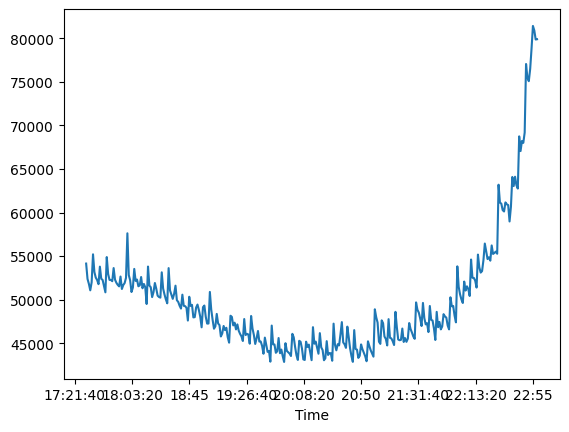

In [10]:
time_groups.plot()

# Stocks

## stock sector

In [11]:
# from src.data.download_data import get_sectors, get_tickers_sp500
# tickers = get_tickers_sp500()
# ticker_sectors = get_sectors(tickers, save=True)

with open('configs/ticker_sectors.yaml') as fh:
    ticker_sectors = yaml.load(fh, Loader=yaml.FullLoader)

In [12]:
list_downloaded_tickers = [ticker[:-4] for ticker in os.listdir('data/ticker_data/')]

In [13]:
downloaded_sectors = {ticker:[ticker_sectors[ticker]] for ticker in list_downloaded_tickers}
df_sectors = pd.DataFrame(downloaded_sectors).T
df_sectors = df_sectors.reset_index()
df_sectors.columns = ['Ticker', 'Sector']
df_sectors.head()

,Ticker,Sector
0,WEC,Utilities
1,TFX,Healthcare
2,GPN,Industrials
3,AOS,Industrials
4,SWK,Industrials


[]

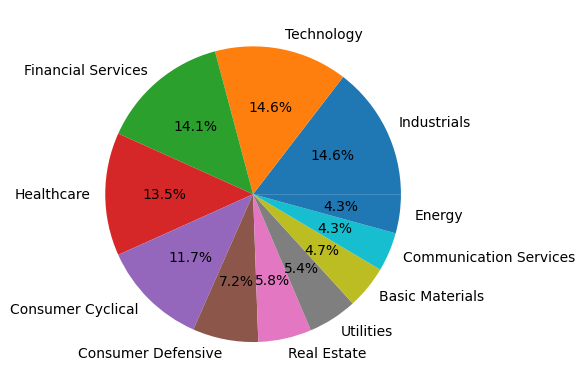

In [14]:
pie_data = df_sectors['Sector'].value_counts()
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')
plt.plot()

## filtered_data

In [15]:
n_stock_data = data.groupby('Stock')['Close'].count()
n_stock_data

Stock
A       28754
AAL     68335
AAPL    82605
ABBV    59486
ABNB    62804
        ...  
XYL     26042
YUM     24632
ZBH     23841
ZION    48580
ZTS     28848
Name: Close, Length: 446, dtype: int64

<Axes: >

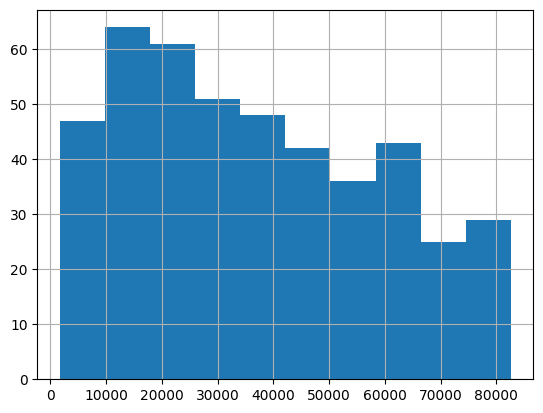

In [ ]:
n_stock_data.hist()

Index(['AAPL', 'TSLA', 'AMD', 'GOOG', 'NVDA', 'MSFT', 'INTC', 'UBER', 'XOM',
       'PYPL', 'MU', 'WFC', 'C', 'CMCSA', 'CSCO', 'BAC', 'JPM', 'DIS', 'GM',
       'PFE', 'NEE', 'OXY', 'USB', 'FCX', 'KO', 'SLB', 'VZ', 'SCHW', 'BMY',
       'MS', 'NEM', 'MRO', 'DAL', 'CCL', 'CVX', 'JNJ', 'MRK', 'CVS', 'DVN',
       'TFC', 'SBUX', 'NKE', 'CSX', 'HAL', 'MDLZ', 'UAL', 'WBA', 'VFC', 'GILD',
       'F'],
      dtype='object', name='Stock')


[]

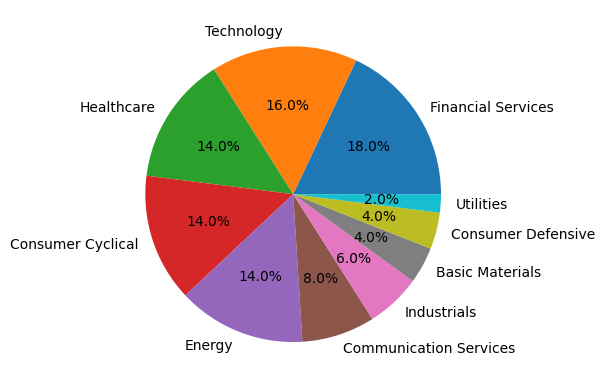

In [20]:
n_best = 50
best_stocks = n_stock_data.sort_values(ascending=False).iloc[:n_best].index
print(best_stocks)

df_sectors_best = df_sectors.query('Ticker in @best_stocks')

pie_data = df_sectors_best['Sector'].value_counts()
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')
plt.plot()

## SP500 biggest

In [27]:
link_sp500_best = 'https://dailypik.com/top-50-companies-sp-500/'
sp500_best_50 = pd.read_html(link_sp500_best)[0]['Symbol'].values.tolist()
sp500_best_50

['MSFT',
 'AAPL',
 'AMZN',
 'NVDA',
 'GOOGL',
 'META',
 'GOOG',
 'BRK.B',
 'TSLA',
 'LLY',
 'UNH',
 'JPM',
 'AVGO',
 'V',
 'XOM',
 'JNJ',
 'HD',
 'MA',
 'PG',
 'MRK',
 'COST',
 'ABBV',
 'ADBE',
 'CRM',
 'CVX',
 'AMD',
 'KO',
 'BAC',
 'WMT',
 'PEP',
 'ACN',
 'MCD',
 'TMO',
 'NFLX',
 'CSCO',
 'INTC',
 'ABT',
 'LIN',
 'WFC',
 'CMCSA',
 'INTU',
 'ORCL',
 'VZ',
 'PFE',
 'DIS',
 'AMGN',
 'QCOM',
 'TXN',
 'DHR',
 'CAT',
 nan]

[]

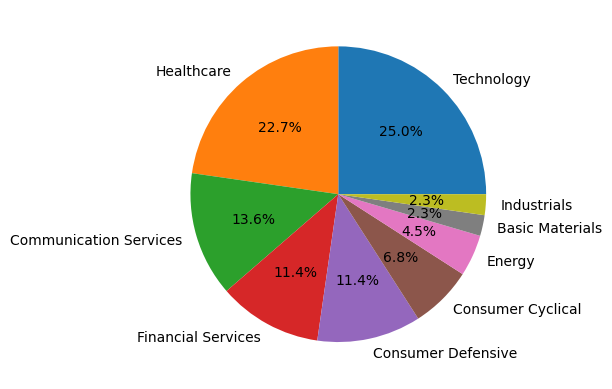

In [30]:
df_sectors_best = df_sectors.query('Ticker in @sp500_best_50')

pie_data = df_sectors_best['Sector'].value_counts()
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')
plt.plot()

<Axes: >

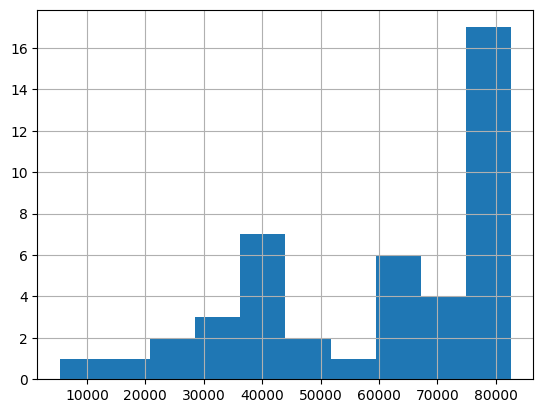

In [34]:
sp500_best_downloaded = [ticker for ticker in sp500_best_50 if ticker in n_stock_data.index]
n_stock_data[sp500_best_downloaded].hist()